In [23]:
import os, sys
import tensorflow as tf
import numpy as np
import time
import csv
import random
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import keras
from keras.layers import Flatten, Input, Dense
from keras.layers import Dropout, Conv1D, Activation, MaxPooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_curve


In [2]:
#load datasets
def get_datasets(diseases, nr_inputs=260):
    datasets = []
    sample_dir = "datasets/samples"
    for idx, disease in enumerate(diseases):
        dataset_dir = os.path.join(sample_dir, str(idx))
        datasets.append([])
        for record in sorted(os.listdir(dataset_dir)):
            record_path = os.path.join(dataset_dir, record)
            with open(record_path) as dis:
                dataset = np.loadtxt(dis)
                if len(dataset) != nr_inputs:
                    print(len(dataset), nr_inputs)
                    continue
                datasets[idx].append(dataset)
    return datasets

In [3]:
def normalize_data(datasets):
    normalized=[]
    for case in datasets:
        cases=[]
        for data in case:
            mu = np.mean(data)
            sigma = np.std(data)
            #fixed = (np.array(data) - mu) / sigma
            fixed = stats.zscore(data)
            cases.append(fixed - min(fixed))
        normalized.append(cases) 
    return normalized

In [4]:
def generate_data(data):
    s_thd = np.random.uniform(low=0.05, high=0.15, size=None)
    m_thd = np.random.uniform(low=-0.2, high=0.2, size=None)
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, [data.shape[0],]) * s_thd + m_thd
    fixed = data + noise
    return fixed-min(fixed)

In [5]:
def generate_datasets(datasets, data_length):
    generate_data_num = [max(data_length) - x for x in data_length]
    for idx, num in enumerate(generate_data_num):
        for i in range(num):
            target_idx = np.random.randint(data_length[idx], size=None)
            target_data = datasets[idx][target_idx]
            datasets[idx].append(generate_data(target_data).tolist())
    return datasets

In [6]:
def split_train_valid(datasets, split=0.9):
    data_length = [len(x) for x in datasets]
    train_length = int(min(data_length) * split)
    train_data = [x[:train_length] for x in datasets]
    valid_data = [x[train_length:] for x in datasets]
    return train_data, valid_data

In [7]:
def get_label(data):
    label= [[idx]*len(x) for idx, x in enumerate(data)]
    label= label[0]+label[1]+label[2]+label[3]+label[4]
    return label

In [8]:
def get_cnn_model(filter_num,filter_size, num_classes=5, 
                  activation='relu', maxpool_size=2, dim=260):
    
    cnn_model = Sequential()
    cnn_model.add(Conv1D (kernel_size=filter_size,
                          filters=filter_num, 
                          input_shape=(dim,1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(20))
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(num_classes))
    cnn_model.add(Activation('softmax'))
    return cnn_model

In [9]:
def fit_model(model, x_train, y_train, x_test, y_test, opt, 
             batch_size=32, epochs=30, shuffle=True,
             loss='categorical_crossentropy',
             metrics=['accuracy'], verbose=0):
    
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=shuffle,
                       verbose=verbose)
    return history

In [10]:
def get_predict(model, datasets):
    predict_list = []
    for case in datasets:
        predict_case=[]
        for data in case:
            data = np.expand_dims(data,1)
            rs = np.argmax(model.predict(np.expand_dims(data,0)))
            predict_case.append(rs)
        predict_list.append(predict_case)
    return predict_list

def get_predict_numpy(model, datasets):
    predict_list = []
    for data in datasets:
        rs = np.argmax(model.predict(np.expand_dims(data,0)))
        predict_list.append(rs)
    return predict_list

In [11]:
def get_total_num(y_true, y_pred, label_num):
    total_nums=[]
    for a in range(label_num):
        nums=[]
        idx = np.array(y_true)==a
        for case in range(label_num):
            nums.append(sum(np.array(y_pred)[idx]==case))
        total_nums.append(nums)
    return total_nums

In [12]:
np.random.seed(0)
heart_diseases = ['N', 'S', 'V', 'F', 'Q']
num_classes=5

In [13]:
datasets = get_datasets(heart_diseases)
datasets = normalize_data(datasets)
datasets = [x[:9000] for x in datasets]
data_length = [len(x) for x in datasets]
datasets = generate_datasets(datasets, data_length)
generated_data_length = [len(x) for x in datasets]

In [14]:
train_data = datasets
train_label = get_label(train_data)
train_data = [x for case in train_data for x in case]
train_data = np.reshape(train_data, (len(train_data), 260, 1))

In [15]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    train_label,
                                                    train_size=0.8)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
valid_data = datasets
valid_label = get_label(valid_data)
valid_label = keras.utils.to_categorical(valid_label, num_classes)

In [89]:
#test case of filter size
filter_size=[4,8,12]
#filter_size=[4,12]


#test case of filter num
filter_num=[8,16,32]
#filter_num=[32]


#test epochs
epochs=30
#learning rate
lr=0.01
#optimizer
opt = keras.optimizers.rmsprop(lr=lr, decay=1e-6)

#history
rs_history=[]
#model
rs_model=[]
#pred
rs_pred=[]
#report
rs_report=[]

for size in filter_size:
    for num in filter_num:
        print("======================================================")

        ##############################
        #get cnn model
        model = get_cnn_model(filter_num=num ,filter_size=size)
        print()
        print('[filter num]{}  [filter size]{}'.format(num,size))
        print("------------------------------------------------------")
        
        ##############################
        #compile and fit model
        print(">>fitting model..")
        history = fit_model(model=model, 
                            x_train=x_train,
                            y_train=y_train,
                            x_test=x_test,
                            y_test=y_test,
                            opt=opt,
                            epochs=epochs,
                            verbose=0,
                            )
        print(">>fitting complete")
        
        ##############################
        #predict label
        print(">>predict model..")
        '''
        predict_list = get_predict(model, valid_data)
        true_list = [[idx]*len(x) for idx,x in enumerate(predict_list)]
        flatten_predict = [x for case in predict_list for x in case]
        flatten_true = [x for case in  true_list for x in case]
        '''
        predict_list = get_predict_numpy(model, x_test)
        print(">>predict complete")
        
        ##############################
        #data evaluation score
        #label/list | precision | recall | f1-score | support
        #       0 |       
        #       1 |
        #       2 |               score                 num
        #       3 |
        #       4 |  
        print()
        print("[scores]")
        print("------------------------------------------------------")
        
        flatten_true=[np.argmax(x) for x in y_test]
        flatten_predict=predict_list
        
        report = classification_report(flatten_true, 
                                    flatten_predict,
                                    target_names=heart_diseases, 
                                    digits=4,
                                    output_dict=True)
        
        ##############################
        #print
        ##############################
        print(report)
        
        ##############################
        #label/pred | 0 | 1 | 2 | 3 | 4 |
        #  0 |                          => sum()=datasets num
        #  1 |                          => sum()=datasets num
        #  2 |         data num         => sum()=datasets num
        #  3 |                          => sum()=datasets num
        #  4 |                          => sum()=datasets num
        ##############################
        r_nums = get_total_num(y_true=flatten_true,
                              y_pred=flatten_predict,
                              label_num=len(heart_diseases))
        print()
        print('[row:label | col:prediction]')
        print("------------------------------------------------------")
        for r in r_nums:
            print(r)
        

        
        ##############################
        #save result
        ##############################
        print()
        print('[save result]')
        rs_history.append(history)
        rs_model.append(model)
        rs_pred.append(flatten_predict)
        rs_report.append(report)
        
        
        print("======================================================")
        print("\n\n")


[filter num]8  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
------------------------------------------------------
{'F': {'recall': 0.5217391304347826, 'f1-score': 0.6834319526627218, 'precision': 0.9903536977491961, 'support': 1771}, 'V': {'recall': 0.991130820399113, 'f1-score': 0.8325960419091966, 'precision': 0.7177840224809313, 'support': 1804}, 'S': {'recall': 0.8833151581243184, 'f1-score': 0.9329110279297437, 'precision': 0.9884075655887736, 'support': 1834}, 'Q': {'recall': 0.9830124575311439, 'f1-score': 0.9838481156134882, 'precision': 0.9846851956891662, 'support': 1766}, 'micro avg': {'recall': 0.874, 'f1-score': 0.874, 'precision': 0.874, 'support': 9000}, 'N': {'recall': 0.9852054794520548, 'f1-score': 0.8992248062015503, 'precision': 0.827046918123275, 'support': 1825}, 'macro avg': {'recall': 0.8728806091882826, 'f1-score': 0.8664023888633402, 'precision': 0.90


[filter num]16  [filter size]12
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
------------------------------------------------------
{'F': {'recall': 0.9983060417843026, 'f1-score': 0.9879854708019, 'precision': 0.9778761061946902, 'support': 1771}, 'V': {'recall': 0.9628603104212861, 'f1-score': 0.9796954314720813, 'precision': 0.9971297359357061, 'support': 1804}, 'S': {'recall': 0.9972737186477645, 'f1-score': 0.9918655097613883, 'precision': 0.9865156418554477, 'support': 1834}, 'Q': {'recall': 0.9960362400906002, 'f1-score': 0.9971655328798185, 'precision': 0.9982973893303064, 'support': 1766}, 'micro avg': {'recall': 0.99, 'f1-score': 0.99, 'precision': 0.99, 'support': 9000}, 'N': {'recall': 0.9956164383561644, 'f1-score': 0.9931675321125991, 'precision': 0.9907306434023991, 'support': 1825}, 'macro avg': {'recall': 0.9900185498600236, 'f1-score': 0.9899758954055574, 'precision': 0.9901

[acc][size : 4][num : 8]:0.9846388888888888
[acc][size : 4][num : 16]:0.9886944444444444
[acc][size : 4][num : 32]:0.9908888888888889


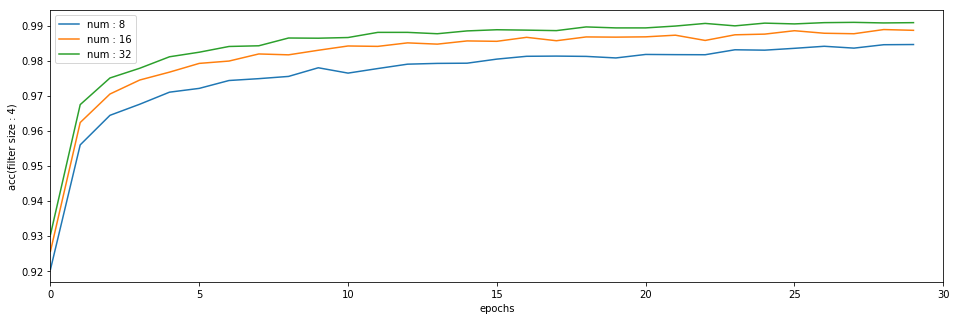

[acc][size : 8][num : 8]:0.9840833333333333
[acc][size : 8][num : 16]:0.9890555555555556
[acc][size : 8][num : 32]:0.992


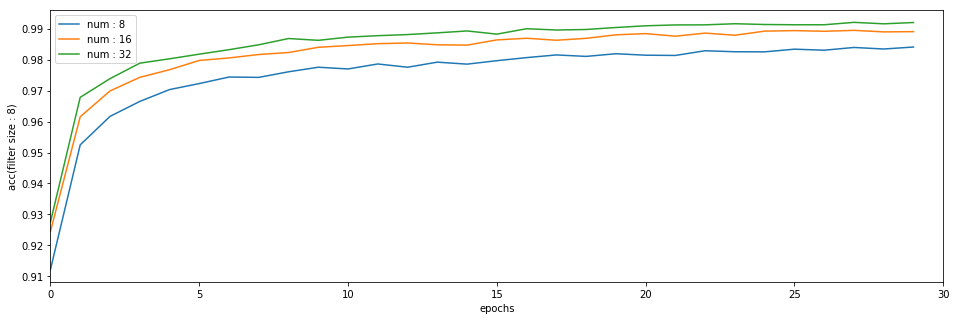

[acc][size : 12][num : 8]:0.9833611111111111
[acc][size : 12][num : 16]:0.98825
[acc][size : 12][num : 32]:0.9921388888888889


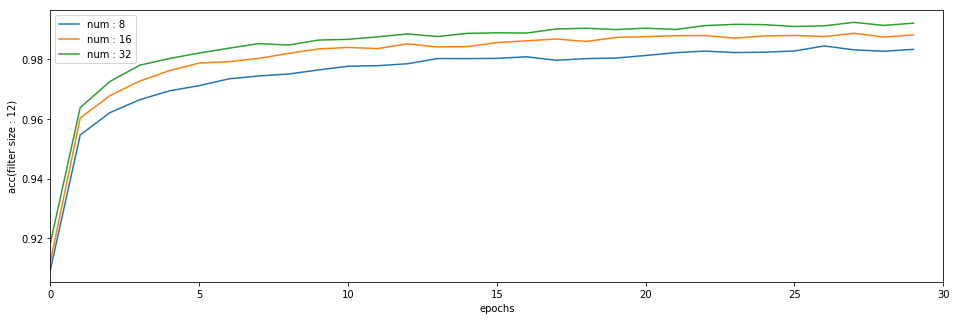

In [105]:
#acc graph 
#graph with each filter size to compare with filter num

for idx in range(len(filter_size)):
    plt.figure(figsize=(16,5))
    for idx2 in range(len(filter_num)):
        plt.plot(rs_history[idx*len(filter_num)+idx2].history['acc'], 
                 label="num : {}".format(filter_num[idx2]))
        plt.xlim((0, epochs))
        plt.legend()
        plt.xlabel('epochs')
        plt.ylabel('acc(filter size : {})'.format(filter_size[idx]))
        print('[acc][size : {}][num : {}]:{}'.format(
            filter_size[idx],
            filter_num[idx2],
            rs_history[idx*len(filter_num)+idx2].history['acc'][-1] ))
    plt.show()

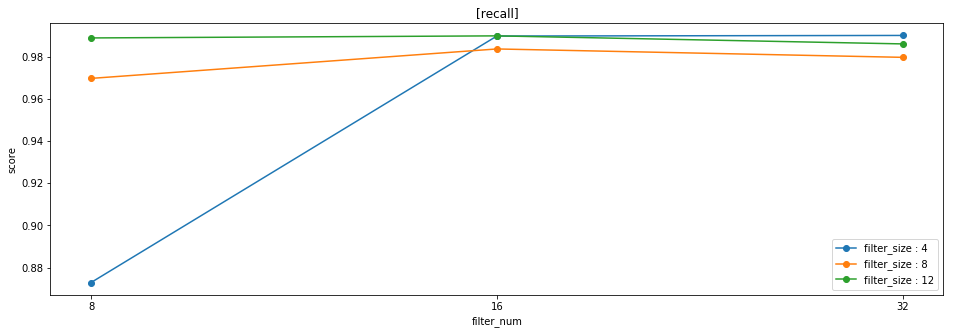

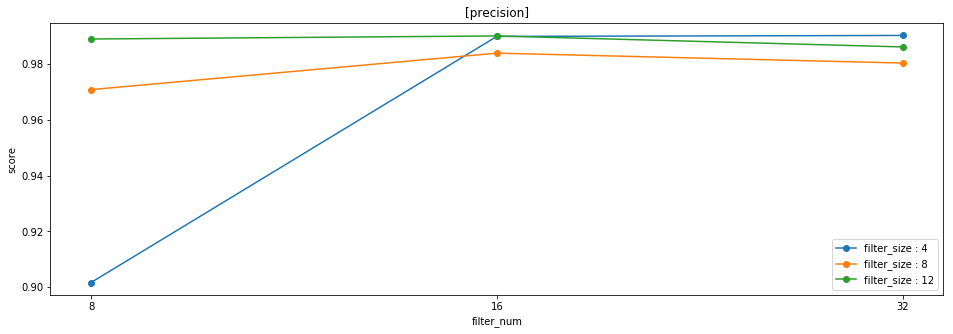

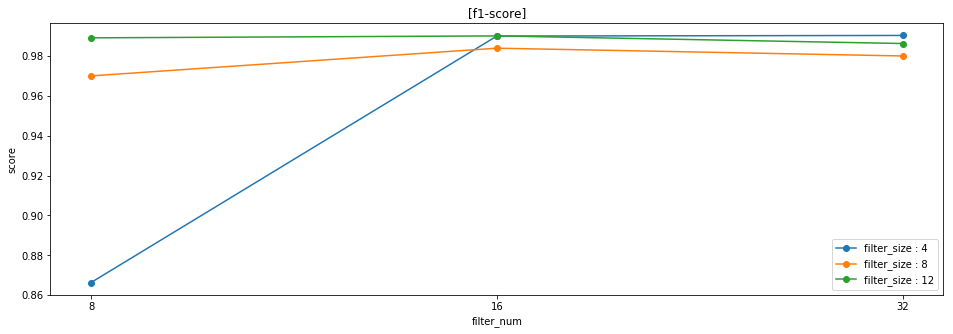

In [97]:
#recall(sen), precision(ppv), f1-score
#graph with each filter size to compare with filter num
plot_list = [str(x) for x in filter_num]
legend = ['filter_size : {}'.format(x) for x in filter_size]
for step, key in enumerate(['recall', 'precision', 'f1-score']):
    plt.figure(figsize=(16,5))
    for idx in range(len(filter_size)):  
        plt.title("[{}]".format(key))
        plt.xlabel('filter_num')
        plt.ylabel('score') 
        y = []
        for idx2 in range(len(filter_num)):
            #average of heart_diseases = ['N', 'S', 'V', 'F', 'Q'] 
            #at same filter size
            row = [rs_report[idx*len(filter_num)+idx2][x][key] for x 
                                                       in heart_diseases]
            y.append(np.mean(row))
        plt.plot(plot_list,y,'o-')
    plt.legend(legend)
    plt.show()

[*]size : 4  /  num : 8
     support          recall           precision        f1-score         
----------------------------------------------------------------
N    1825.0000        0.9852           0.8270           0.8992           S    1834.0000        0.8833           0.9884           0.9329           V    1804.0000        0.9911           0.7178           0.8326           F    1771.0000        0.5217           0.9904           0.6834           Q    1766.0000        0.9830           0.9847           0.9838           

[*]size : 4  /  num : 16
     support          recall           precision        f1-score         
----------------------------------------------------------------
N    1825.0000        0.9901           0.9901           0.9901           S    1834.0000        0.9918           0.9891           0.9905           V    1804.0000        0.9739           0.9932           0.9835           F    1771.0000        0.9989           0.9795           0.9891           Q    1766.0000

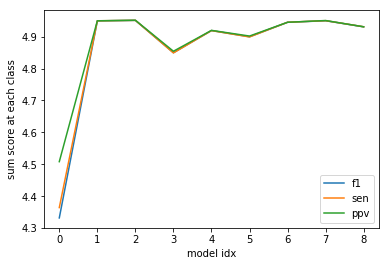

[*]Best f1 score Index: 2
[*]Best sen score Index: 2
[*]Best ppv score Index: 2


In [120]:
#print score values
idx=0
f1_score_mean = [0.] * len(rs_model)
sen_score_mean = [0.] * len(rs_model)
ppv_score_mean = [0.] * len(rs_model)

print_cols = ['support', 'recall', 'precision', 'f1-score']
for size in filter_size:
    for num in filter_num:
        print("[*]size : {}  /  num : {}".format(size, num))
        data = rs_report[idx]
        print("{0:<5}".format(""), end='')
        for col in print_cols:
             print("{0:<17}".format(col), end='')
        print()
        print("----------------------------------------------------------------")
        for key in heart_diseases:
            print("{0:<5}".format(key), end='')
            for val in print_cols:
                print("{0:<15.4f}".format(round(data[key][val],4)), 
                                                         end='  ')

            f1_score_mean[idx] += data[key]['f1-score']
            sen_score_mean[idx] += data[key]['recall']
            ppv_score_mean[idx] += data[key]['precision']
        print("\n")
        idx+=1


plt.plot(f1_score_mean, label='f1')
plt.plot(sen_score_mean, label='sen')
plt.plot(ppv_score_mean, label='ppv')
plt.xlabel('model idx')
plt.ylabel('sum score at each class')
plt.legend()
plt.show()
    
best_model_idx = np.argmax(f1_score_mean)
best_sen_idx = np.argmax(sen_score_mean)
best_ppv_idx = np.argmax(ppv_score_mean)
print("[*]Best f1 score Index: {}".format(best_model_idx))
print("[*]Best sen score Index: {}".format(best_sen_idx))
print("[*]Best ppv score Index: {}".format(best_ppv_idx))
##8 => size : 12 / num : 32

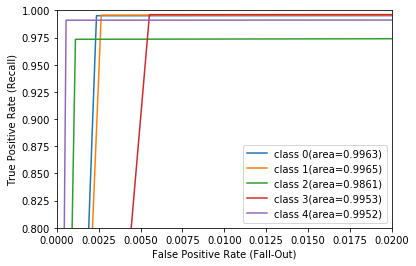

In [99]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

#test model
idx=best_model_idx
# Plot linewidth.
lw = 2
#get label
tty = np.array(y_test)
ttp = np.array(rs_pred[idx])

n_values = np.max(ttp) + 1
y_score =  np.eye(n_values)[ttp]

#plot roc curve
n_classes=len(heart_diseases)
fpr = [None] * len(heart_diseases)
tpr = [None] * len(heart_diseases)
thr = [None] * len(heart_diseases)
roc_auc=[None] * len(heart_diseases)

#endx=1.0
#endy=1.0
endx=0.02#zoom
starty=0.80#zoom

###plot roc 0 ~ 1 range
for i in range(len(heart_diseases)):
    fpr[i], tpr[i], thr[i] = roc_curve(tty[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], 
             label="class {}(area={})".format(i,round(roc_auc[i],4)))
    
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0,endx)
plt.ylim(starty,1.0)
plt.legend()
plt.show()

### plot multi classification roc curve

https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/


### calulate acc, spec ..

https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [100]:
rs_model[0].summary()
'''
Total params: 4,955
Trainable params: 4,831
Non-trainable params: 124
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 257, 8)            40        
_________________________________________________________________
batch_normalization_61 (Batc (None, 257, 8)            32        
_________________________________________________________________
activation_85 (Activation)   (None, 257, 8)            0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 128, 8)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 125, 8)            264       
_________________________________________________________________
batch_normalization_62 (Batc (None, 125, 8)            32        
_________________________________________________________________
activation_86 (Activation)   (None, 125, 8)            0         
__________

'\nTotal params: 4,955\nTrainable params: 4,831\nNon-trainable params: 124\n'

In [101]:
rs_model[8].summary()
'''
Total params: 43,563
Trainable params: 43,247
Non-trainable params: 316
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 249, 32)           416       
_________________________________________________________________
batch_normalization_101 (Bat (None, 249, 32)           128       
_________________________________________________________________
activation_141 (Activation)  (None, 249, 32)           0         
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 124, 32)           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 113, 32)           12320     
_________________________________________________________________
batch_normalization_102 (Bat (None, 113, 32)           128       
_________________________________________________________________
activation_142 (Activation)  (None, 113, 32)           0         
__________

'\nTotal params: 43,563\nTrainable params: 43,247\nNon-trainable params: 316\n'